In [ ]:
import nb_setup
import numpy as np
import matplotlib.pyplot as plt

from gpdm import GPDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
TRAIN_TRIALS = WALK_TRIALS_TRAIN
TEST_TRIALS = WALK_TRIALS_TEST
gpdm_save_name = "walk_gpdm"

In [3]:
print(f"Number of train trials: {len(TRAIN_TRIALS)}")
print(f"Number of test trials: {len(TEST_TRIALS)}")

Number of train trials: 10
Number of test trials: 21


In [4]:
reduced_columns = TRAIN_TRIALS[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [5]:
train_dfs = [trial.as_dataframe() for trial in TRAIN_TRIALS]
train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in train_dfs]


In [6]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [7]:
gpdm = GPDM(
        D=DOFs,
        d=d,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [8]:
for train_arr in train_arrs[0:6]:
    gpdm.add_data(train_arr)

print('Num. of sequences = '+str(gpdm.num_sequences)+' [Data points = '+str(np.concatenate(gpdm.observations_list, 0).shape[0])+']')


Num. of sequences = 6 [Data points = 365]



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 7.3639e+06
Update time: 0.19371962547302246

GPDM Opt. EPOCH: 10
Running loss: 1.5882e+06
Update time: 2.280083656311035

GPDM Opt. EPOCH: 20
Running loss: 6.4929e+05
Update time: 1.5664658546447754

GPDM Opt. EPOCH: 30
Running loss: 3.3323e+05
Update time: 1.1613810062408447

GPDM Opt. EPOCH: 40
Running loss: 2.0663e+05
Update time: 1.0594909191131592

GPDM Opt. EPOCH: 50
Running loss: 1.3710e+05
Update time: 1.2771170139312744

GPDM Opt. EPOCH: 60
Running loss: 9.2503e+04
Update time: 1.0184082984924316

GPDM Opt. EPOCH: 70
Running loss: 6.8194e+04
Update time: 1.0001988410949707

GPDM Opt. EPOCH: 80
Running loss: 5.5827e+04
Update time: 1.0907392501831055

GPDM Opt. EPOCH: 90
Running loss: 4.8660e+04
Update time: 1.1705787181854248

GPDM Opt. EPOCH: 100
Running loss: 4.3598e+04
Update time: 1.6435410976409912

GPDM Opt. EPOCH: 110
Running loss: 3.9291e+04
Update time: 1.2770235538482666

GPDM Opt. EPOCH: 120
Running lo

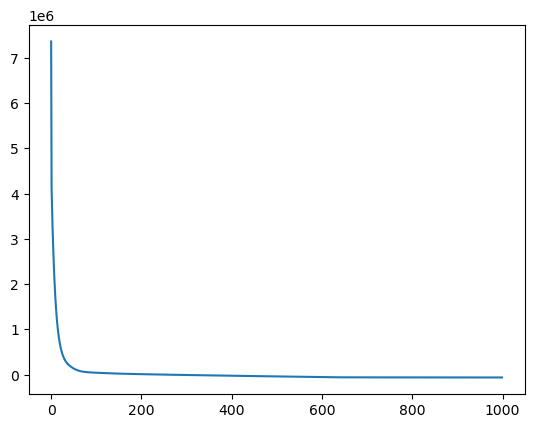

In [9]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

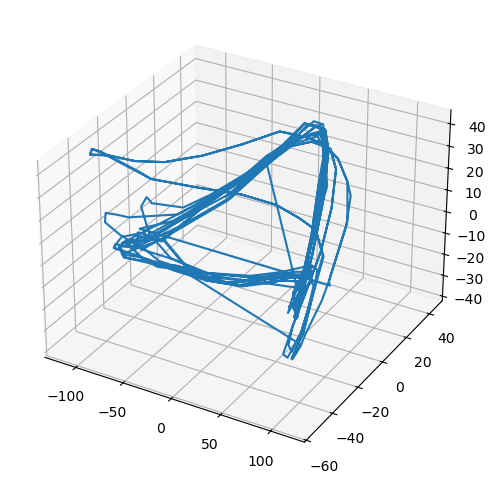

In [10]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X = gpdm.X.detach().numpy()
ax.plot(X[:, 0], X[:, 1], X[:, 2])